In [1]:
import numpy as np 
import torch
from torch import nn
from torch import tensor, Tensor
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.utils import save_image

from sklearn.cluster import MiniBatchKMeans, KMeans
from tqdm import tqdm

In [2]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

ptdec_dir = os.path.join(project_dir, "pt-dec/")
if ptdec_dir not in sys.path:
    sys.path.append(ptdec_dir)

In [11]:
from ptdec import model as ptdec_model
from ptdec.dec import DEC
from ptdec.cluster import ClusterAssignment
from ptdec.utils import cluster_accuracy

In [4]:
def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [5]:
''' Pre-imputation '''
class Noise(nn.Module):
    def __init__(self):
        super(Noise, self).__init__()
    
    def forward(self, x):
        if self.training:
            return x * (tensor(x.data.new(x.size()).normal_(0, 0.1)) > -.1).type_as(x)
        
        return x

''' This class contains a Layer-wise training '''
class AutoEncoder(nn.Module):
    def __init__(self, n_in, n_out, g1_relu=True, g2_relu=True):
        super(AutoEncoder, self).__init__()

        self.encode = nn.Sequential(
                nn.Dropout(p=0.2),
                # Noise(),
                nn.Linear(n_in, n_out), 
                nn.ReLU(inplace=True) if g1_relu else nn.Identity()
            )

        self.decode = nn.Sequential(
                nn.Dropout(p=0.2),
                # Noise(),
                nn.Linear(n_out, n_in),
                nn.ReLU(inplace=True) if g2_relu else nn.Identity()
            )

        for m in self.modules():
            self.weight_init(m)

        self.criterion = nn.MSELoss(reduction='mean')
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1, momentum=0.5)

    def get_encode(self, dropout=False):
        encode = []
        for module in self.encode:
            if dropout or isinstance(module, nn.Linear) or isinstance(module, nn.ReLU):
                encode.append(module)
        
        return nn.Sequential(*encode)

    def get_decode(self, dropout=False):
        decode = []
        for module in self.decode:
            if dropout or isinstance(module, nn.Linear) or isinstance(module, nn.ReLU):
                decode.append(module)
        
        return nn.Sequential(*decode)

    def forward(self, x: Tensor) -> Tensor:
        # Train each autoencoder individually
        x = x.detach()
        y = self.encode(x)

        if self.training:
            x_reconstruct = self.decode(y)
            loss = self.criterion(x_reconstruct, tensor(x.data, requires_grad=False))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return y.detach()

    def weight_init(self, module: nn.Module) -> None:
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight.data)

    def reconstruct(self, x: Tensor) -> Tensor:
        return self.decoder(x)


class SDAE(nn.Module):
    def __init__(self, input_size):
        super(SDAE, self).__init__()

        ''' We use rectified linear units (ReLUs) in all encoder/decoder pairs, except for g2 of the first pair
            (it needs to reconstruct input data that may have positive  and  negative  values, such  as  zero-mean  images) and g1 of the last 
            pair (so the final data embedding retains full information)
        '''

        self.ae = [ AutoEncoder(input_size, 500, g1_relu=True, g2_relu=False), 
                    AutoEncoder(500, 500), 
                    AutoEncoder(500, 2000), 
                    AutoEncoder(2000, 10, g1_relu=False, g2_relu=True)
                    ]
          
        self.sdae = nn.Sequential(
                        *list(map(lambda ae: ae.get_encode(False), self.ae)), 
                        *list(map(lambda ae: ae.get_decode(False), self.ae[::-1])) 
                    )

        self.ae = nn.Sequential(*self.ae)

    def layer_wise_training(self, x):
        self.ae(x)

    def get_encode(self, dropout=False):
        return nn.Sequential(
            *list(map(lambda ae: ae.get_encode(dropout), self.ae))
        )
        # return self.sdae[:len(self.ae)]

    def forward(self, x):
        return self.sdae(x)


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# transformToTensor = Compose([ToTensor()])
transformToTensor = Compose([
            ToTensor(), # first, convert image to PyTorch tensor
            Normalize((0.1307,), (0.3081,)), # normalize inputs
            Lambda(lambda x: torch.flatten(x)) # Auto-flatten
        ])



train_dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=False, download=False, transform=transformToTensor)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=0) 

model = SDAE(28*28).to(device)

## Layer-wise training (It's useless)

In [5]:
for epoch in tqdm(range(100)):
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        model.layer_wise_training(inputs.flatten(1))

100%|██████████| 100/100 [17:18<00:00, 10.39s/it]


## SDAE Training

In [6]:
n_epoch = 600
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 250, gamma=0.1)

model.train()

eval_inputs, eval_targets = next(iter(test_loader))
eval_inputs = eval_inputs.to(device)
eval_targets = eval_targets.to(device)

dropout = nn.Dropout(0.8)

epoch_iterator = tqdm(
    range(n_epoch),
    leave=True,
    unit="epoch",
    postfix={"lss": "%.6f" % 0.0, "vls": "%.6f" % -1,},
)

for epoch in epoch_iterator:
    for idx, (inputs, _) in enumerate(dataloader):
        inputs = inputs.flatten(1).to(device)

        optimizer.zero_grad()

        outputs = model(dropout(inputs))

        loss = criterion(outputs, inputs)
        loss_value = float(loss.item())        
        loss.backward()

        optimizer.step(closure=None)

        if idx % 25 == 0:
            model.eval()
            outputs = model(eval_inputs.flatten(1))
            eval_loss_value = float((criterion(outputs, eval_inputs.flatten(1))).item())
            epoch_iterator.set_postfix(
                lss="%.6f" % loss_value, vls="%.6f" % eval_loss_value,
            )
            model.train()
    
    scheduler.step()

100%|██████████| 600/600 [1:38:44<00:00,  9.87s/epoch, lss=0.218792, vls=0.171797]


### Load training

In [8]:
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

### Save training

In [7]:
torch.save(model.state_dict(), "model.pth")

In [7]:

model.eval()
eval_inputs, eval_targets = next(iter(test_loader))
save_image(eval_inputs.cpu(), 'inputs.png')

eval_inputs = eval_inputs.to(device)

outputs = model(eval_inputs.flatten(1))
save_image(to_img(outputs.cpu()), 'outputs.png')

# DEC

## PT-DEC

In [9]:
dec_model = DEC(cluster_number=10, hidden_dimension=10, encoder=model.get_encode(False)).to(device)
dec_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

ptdec_model.train(
    dataset=train_dataset,
    model=dec_model,
    epochs=100,
    batch_size=256,
    optimizer=dec_optimizer,
    stopping_delta=0.000001,
    cuda=True,
)

100%|██████████| 235/235 [00:12<00:00, 19.26batch/s, acc=0.8396, dlb=0.0001, epo=99, lss=0.03195473]


In [39]:
torch.save(dec_model.state_dict(), "dec_model.pth")

In [36]:
predicted, actual = ptdec_model.predict(
        test_dataset, dec_model, 1024, silent=True, return_actual=True, cuda=True
    )

actual = actual.cpu().numpy()
predicted = predicted.cpu().numpy()
reassignment, accuracy = cluster_accuracy(actual, predicted)

print("Final DEC accuracy: %s" % accuracy)

Final DEC accuracy: 0.8417


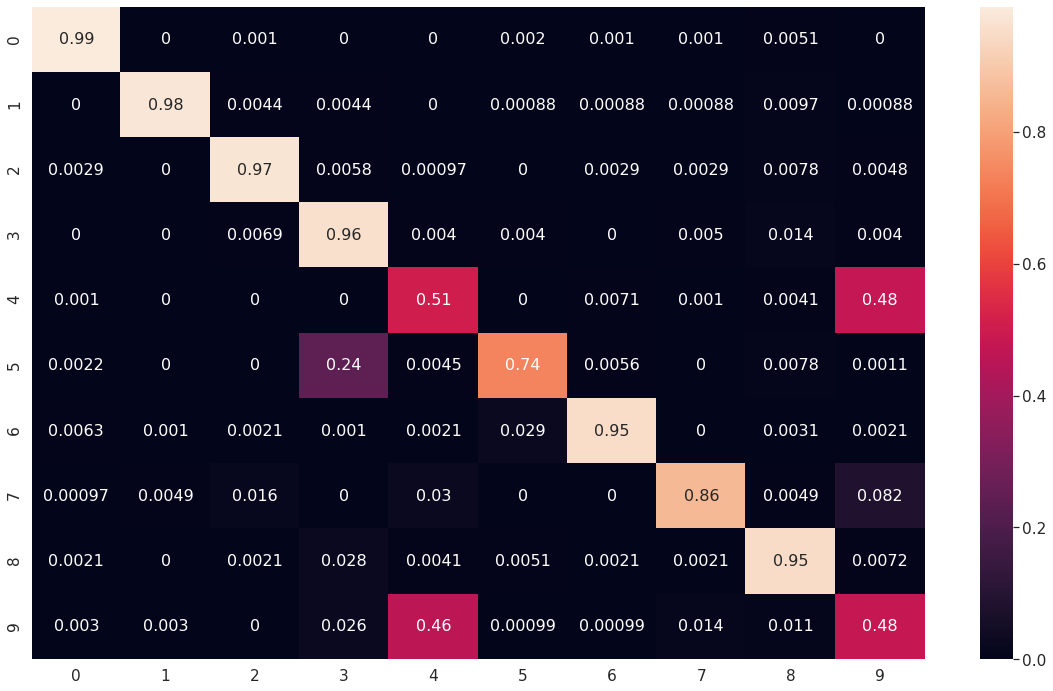

In [37]:
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns

predicted_reassigned = [
    reassignment[item] for item in predicted
] 

confusion_matrix = sklearn.metrics.confusion_matrix(actual, predicted_reassigned, normalize='true')
normalised_confusion = (
    confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
)

df_cm = pd.DataFrame(confusion_matrix)
plt.figure(figsize=(20,12))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

## Custom (no working)

In [7]:
from torch.nn import Parameter
from typing import Optional

'''
Code extracted from: https://github.com/vlukiyanov/pt-dec

This module returns the Q output which can be interpreted as the probability of 
assigning sample i to cluster j.
'''

class ClusterAssignment(nn.Module):
    def __init__(
        self,
        cluster_number: int,
        embedding_dimension: int,
        alpha: float = 1.0,
        cluster_centers: Optional[Tensor] = None,
    ) -> None:
        """
        Module to handle the soft assignment, for a description see in 3.1.1. in Xie/Girshick/Farhadi, where the Student's t-distribution is used measure similarity between feature vector and each cluster centroid.
        :param cluster_number: number of clusters
        :param embedding_dimension: embedding dimension of feature vectors
        :param alpha: parameter representing the degrees of freedom in the t-distribution, default 1.0
        :param cluster_centers: clusters centers to initialise, if None then use Xavier uniform
        """
        super(ClusterAssignment, self).__init__()
        self.embedding_dimension = embedding_dimension
        self.cluster_number = cluster_number
        self.alpha = alpha
        if cluster_centers is None:
            initial_cluster_centers = torch.zeros(
                self.cluster_number, self.embedding_dimension, dtype=torch.float
            )
            nn.init.xavier_uniform_(initial_cluster_centers)
        else:
            initial_cluster_centers = cluster_centers
        
        self.cluster_centers = Parameter(initial_cluster_centers, requires_grad=True)

    def forward(self, batch: Tensor) -> Tensor:
        """
        Compute the soft assignment for a batch of feature vectors, returning a batch of assignments
        for each cluster.
        :param batch: FloatTensor of [batch size, embedding dimension]
        :return: FloatTensor [batch size, number of clusters]
        """
        norm_squared = torch.sum((batch.unsqueeze(1) - self.cluster_centers) ** 2, 2)
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        power = float(self.alpha + 1) / 2
        numerator = numerator ** power
        return numerator / torch.sum(numerator, dim=1, keepdim=True)

In [8]:
'''
Code extracted from: https://github.com/vlukiyanov/pt-dec
'''

class DEC(nn.Module):
    def __init__(
        self,
        cluster_number: int,
        hidden_dimension: int,
        encoder: torch.nn.Module,
        alpha: float = 1.0,
    ):
        """
        Module which holds all the moving parts of the DEC algorithm, as described in
        Xie/Girshick/Farhadi; this includes the AutoEncoder stage and the ClusterAssignment stage.
        :param cluster_number: number of clusters
        :param hidden_dimension: hidden dimension, output of the encoder
        :param encoder: encoder to use
        :param alpha: parameter representing the degrees of freedom in the t-distribution, default 1.0
        """
        super(DEC, self).__init__()
        self.encoder = encoder
        self.hidden_dimension = hidden_dimension
        self.cluster_number = cluster_number
        self.alpha = alpha
        self.assignment = ClusterAssignment(
            cluster_number, self.hidden_dimension, alpha
        )

    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        """
        Compute the cluster assignment using the ClusterAssignment after running the batch
        through the encoder part of the associated AutoEncoder module.
        :param batch: [batch size, embedding dimension] FloatTensor
        :return: [batch size, number of clusters] FloatTensor
        """
        return self.assignment(self.encoder(batch))

In [9]:
dec_model = DEC(10, 10, model.get_encode(False)).to(device)
kmeans = KMeans(n_clusters=dec_model.cluster_number, n_init=20)

In [26]:
dec_model.load_state_dict(torch.load('dec_model.pth'))

<All keys matched successfully>

In [10]:
from typing import Optional
from scipy.optimize import linear_sum_assignment

def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

def target_distribution(batch: torch.Tensor) -> torch.Tensor:
    """
    Compute the target distribution p_ij, given the batch (q_ij), as in 3.1.3 Equation 3 of
    Xie/Girshick/Farhadi; this is used the KL-divergence loss function.
    :param batch: [batch size, number of clusters] Tensor of dtype float
    :return: [batch size, number of clusters] Tensor of dtype float
    """
    weight = (batch ** 2) / torch.sum(batch, 0)
    return (weight.t() / torch.sum(weight, 1)).t()

def predict(model, dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    features = []
    actual = []
    model.eval()
    for inputs, targets in dataloader:
        actual.append(targets)
        inputs = inputs.to(device)

        features.append( model(inputs.flatten(1)).detach().cpu() )  # move to the CPU to prevent out of memory on the GPU
        
    return torch.cat(features).max(1)[1], torch.cat(actual).long()
    

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kmeans = KMeans(n_clusters=dec_model.cluster_number, n_init=20)

n_epoch = 500

features = []
actual = []
for index, (inputs, targets) in enumerate(dataloader):
    inputs = inputs.to(device)
    
    actual.append(targets)
    features.append(dec_model.encoder(inputs.flatten(1)).detach().cpu())
    
actual = torch.cat(actual).long()
predicted = kmeans.fit_predict(torch.cat(features).numpy())
predicted_previous = torch.tensor(np.copy(predicted), dtype=torch.long)
_, accuracy = cluster_accuracy(predicted, actual.cpu().numpy())

cluster_centers = torch.tensor(
    kmeans.cluster_centers_, dtype=torch.float, requires_grad=True
).to(device)

with torch.no_grad():
    dec_model.state_dict()['assignment.cluster_centers'].copy_(cluster_centers)

criterion = nn.KLDivLoss(reduction='mean')
# criterion = nn.KLDivLoss(size_average=False)
# optimizer = torch.optim.Adam(dec_model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(dec_model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 200, gamma=0.1)
delta_label = None

epoch_iterator = tqdm(
    range(n_epoch),
    leave=True,
    unit="epoch",
    postfix={"lss": "%.6f" % 0.0, "vls": "%.6f" % -1,"acc": "%.6f" % -1,},
)

eval_inputs, eval_targets = next(iter(test_loader))
eval_inputs = eval_inputs.to(device)
eval_targets = eval_targets.to(device)

# accuracy = -1
for epoch in epoch_iterator:
    # Training bitch!
    features = []

    dec_model.train()    
    for idx, (inputs, targets) in enumerate(dataloader):    
        inputs = inputs.flatten(1).to(device)
        output = dec_model(inputs)

        target = target_distribution(output).detach()
        # loss = criterion(output.log(), target)

        loss = criterion(output.log(), target) 
        loss_value = float(loss.item())  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        features.append(dec_model.encoder(inputs).detach().cpu())

        if idx % 25 == 0:
            model.eval()
            outputs = dec_model(eval_inputs.flatten(1))
            target = target_distribution(outputs).detach()
            loss = criterion(outputs.log(), target)
            eval_loss_value = float(loss.item())
            # eval_loss_value = float((criterion(outputs.log(), target).item()))
            epoch_iterator.set_postfix(
                lss="%.6f" % loss_value, vls="%.6f" % eval_loss_value, acc="%.6f" % accuracy
            )
            model.train()

    predicted, actual = predict(dec_model, dataloader)
    delta_label = (
            float((predicted != predicted_previous).float().sum().item()) / predicted_previous.shape[0]
        )

    # if stopping_delta is not None and delta_label < stopping_delta:
    #     print(
    #         'Early stopping as label delta "%1.5f" less than "%1.5f".'
    #         % (delta_label, stopping_delta)
    #     )
    #     break

    predicted_previous = predicted
    print(predicted.cpu().numpy()[:10])
    print(actual.cpu().numpy())
    _, accuracy = cluster_accuracy(actual.cpu().numpy(), predicted.cpu().numpy())

    epoch_iterator.set_postfix(
            lss="%.6f" % loss_value, vls="%.6f" % eval_loss_value, acc="%.6f" % accuracy
        )
    
    scheduler.step()


    # print("Epoch: {}; Acc.: {}".format(epoch, accuracy))

13e-02, 9.0809e-02, 3.2838e-02, 3.7134e-01, 7.3281e-02,
         7.2232e-02, 2.3035e-02, 7.8847e-02, 6.8658e-02],
        [2.9137e-02, 2.6128e-02, 6.2468e-01, 3.2436e-02, 1.6662e-02, 2.6394e-02,
         4.7417e-02, 2.6492e-02, 1.4773e-01, 2.2921e-02],
        [1.1161e-02, 1.9756e-02, 2.3693e-02, 8.8066e-01, 3.2901e-03, 1.1390e-02,
         1.3537e-02, 8.6800e-03, 1.1702e-02, 1.6133e-02],
        [5.3915e-03, 3.6753e-02, 1.0063e-02, 1.1063e-02, 6.2956e-03, 1.8056e-02,
         1.2608e-02, 8.7358e-03, 1.6999e-02, 8.7403e-01],
        [3.1436e-02, 3.2157e-02, 3.5254e-02, 1.0002e-02, 2.6944e-02, 7.4701e-01,
         3.9444e-02, 2.4475e-02, 2.7067e-02, 2.6212e-02]], device='cuda:0')
tensor([[1.1047e-01, 3.7913e-02, 2.1385e-01, 1.9955e-02, 7.4808e-02, 1.2564e-01,
         2.1699e-01, 5.6614e-02, 1.0563e-01, 3.8122e-02],
        [1.2928e-02, 6.4858e-03, 3.1301e-02, 8.9375e-03, 1.2849e-02, 5.8833e-03,
         1.5760e-02, 1.4575e-02, 8.8369e-01, 7.5922e-03],
        [5.4252e-03, 9.4797e-03, 3

KeyboardInterrupt: 

In [14]:
torch.save(dec_model.state_dict(), "dec_model.pth")

## Predict

In [13]:
def predict(model, dataloader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    features = []
    actual = []
    model.train()
    for inputs, targets in dataloader:
        actual.append(targets)
        inputs = inputs.to(device)

        features.append( model(inputs.flatten(1)).detach().cpu() )  # move to           the CPU to prevent out of memory on the GPU
        
    return torch.cat(features).max(1)[1], torch.cat(actual).long()

In [14]:
output, targets = predict(dec_model, test_loader)

In [15]:
print(output)

tensor([0, 2, 4,  ..., 7, 5, 3])


In [16]:
print(targets)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [46]:
import sklearn
from sklearn.metrics import plot_confusion_matrix

confusion_matrix = sklearn.metrics.confusion_matrix(targets, output, normalize='true')

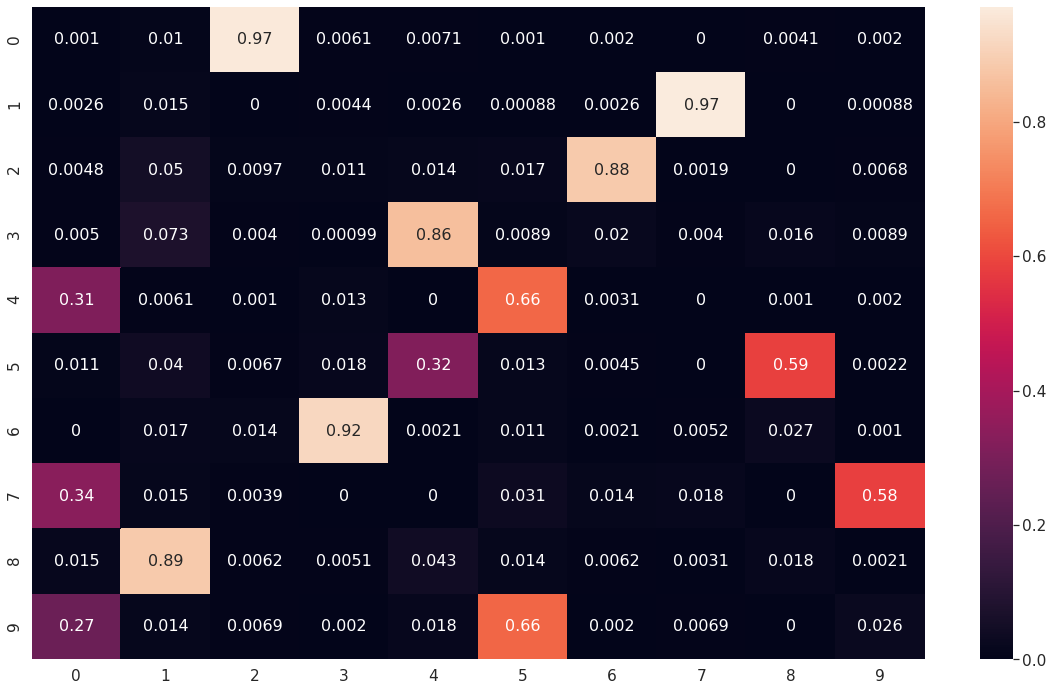

In [47]:
import seaborn as sn
import pandas as pd
from matplotlib import pyplot as plt 

df_cm = pd.DataFrame(confusion_matrix)
plt.figure(figsize=(20,12))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

# To remove

In [6]:
batch = torch.arange(10).reshape((5,2))
print(batch.unsqueeze(1))

tensor([[[0, 1]],

        [[2, 3]],

        [[4, 5]],

        [[6, 7]],

        [[8, 9]]])
